### This notebook will utilize a standard BERT model

### Just using the Title string as the feature

### The input to the neural network will be the pooled_token from BERT

### Output will be whether or not the question has a score of higher than 1

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import pandas as pd

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

2022-11-15 22:22:30.932325: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from transformers import BertTokenizer, TFBertModel

In [6]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [20]:
# bring in the data
questions_data = pd.read_csv("processed_questions.csv")

In [21]:
questions_data.head(2)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Id,OwnerUserId,CreationDate,Score,Title,Body,highest_answer_score,num_answers,has_positive_answer,Full_Text,Title_Word_Count,Body_Word_Count
0,0,0,0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,12,4,1,How can I find the full path to a font from it...,17,70
1,1,1,1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,2,1,Get a preview JPEG of a PDF on Windows? <p>I h...,9,38


In [22]:
train, test = train_test_split(questions_data, test_size=0.2)

In [33]:
train_examples = list(train['Title'])
train_labels = list(train['has_positive_answer'])

In [34]:
test_examples = list(test['Title'])
test_labels = list(test['has_positive_answer'])

In [35]:
max_length = 20 # seems like this encompasses most titles

In [46]:
x_train = bert_tokenizer(train_examples,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = tf.convert_to_tensor(train_labels)

In [47]:
x_test = bert_tokenizer(test_examples,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = tf.convert_to_tensor(test_labels)

In [48]:
def create_bert_classification_model(bert_model,
                                     train_layers=-1,
                                     hidden_size = 200, 
                                     dropout=0.3,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes
    """
    if train_layers == -1:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    else:
        # Restrict training to the train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
          
        
        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooled_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [49]:
bert_classification_model = create_bert_classification_model(bert_model, train_layers=-1)

In [50]:
bert_classification_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 20)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 20)]        0           []                               
 er)                                                                                              
                                                                                            

In [51]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=2
)  

Epoch 1/2
15183/15183 [==============================] - 7392s 486ms/step - loss: 0.6254 - accuracy: 0.6705 - val_loss: 0.6254 - val_accuracy: 0.6674
Epoch 2/2
15183/15183 [==============================] - 6441s 424ms/step - loss: 0.6207 - accuracy: 0.6713 - val_loss: 0.6188 - val_accuracy: 0.6676


In [45]:
# how to make confusion matrix:
# https://androidkt.com/keras-confusion-matrix-in-tensorboard/

tensorflow.python.framework.ops.EagerTensor

In [52]:
# https://www.tensorflow.org/guide/keras/save_and_serialize
# how to save models

In [53]:
bert_classification_model.save('models/bert-model-pooled-token-full-text')

INFO:tensorflow:Assets written to: models/bert-model-pooled-token/assets


INFO:tensorflow:Assets written to: models/bert-model-pooled-token/assets


In [55]:
y_pred_raw = bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])

3796/3796 [==============================] - 1339s 352ms/step


In [81]:
y_pred = (y_pred_raw > 0.5).astype(int)

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

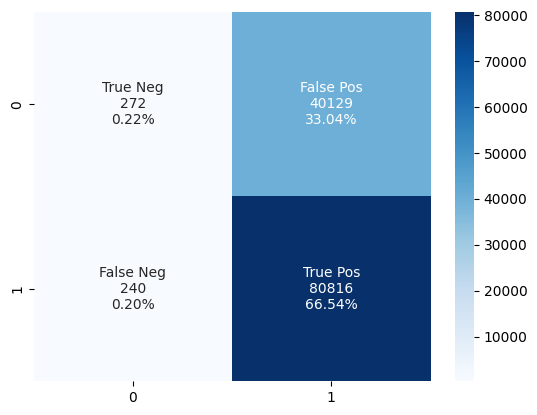

In [112]:
group_names = ["True Neg", "False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, fmt="", cmap='Blues', annot=labels)

<AxesSubplot:ylabel='Count'>

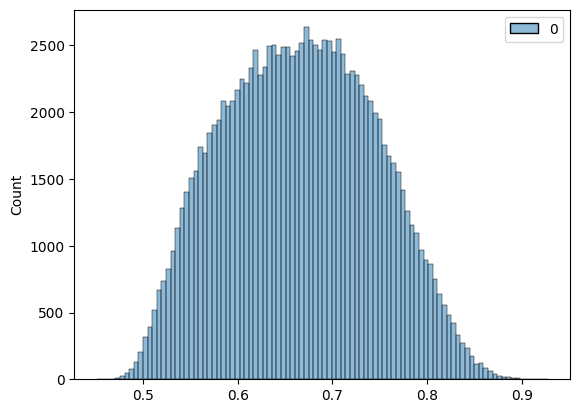

In [79]:
import seaborn as sns
sns.histplot(y_pred_raw)

In [80]:
np.sum(y_pred_raw < 0.5)

512